# 1. 使用 Rdkit.Chem.RWMol 逐步生成分子
RDKit 的 RWMol (可写的分子对象) 允许动态添加原子和键，以编程方式创建分子：

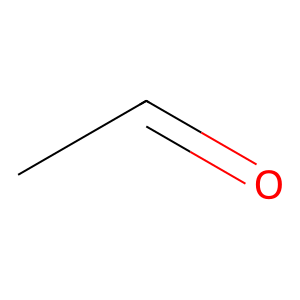

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw

# 创建一个空分子
mol = Chem.RWMol()

# 添加碳原子
c1 = mol.AddAtom(Chem.Atom(6))  # 碳
c2 = mol.AddAtom(Chem.Atom(6))  # 碳
o1 = mol.AddAtom(Chem.Atom(8))  # 氧

# 添加键
mol.AddBond(c1, c2, Chem.BondType.SINGLE)
mol.AddBond(c2, o1, Chem.BondType.DOUBLE)

# 转换为标准Mol对象
final_mol = mol.GetMol()

# 显示分子
Draw.MolToImage(final_mol)

# 2. 使用 BRICS 进行片段组装
RDKit 提供 BRICS (Breaking of Retrosynthetically Interesting Chemical Substructures) 方法，用于基于已有片段合成新分子。

In [2]:
from rdkit.Chem import BRICS

mol = Chem.MolFromSmiles("CC(=O)Oc1ccccc1C(=O)O")
sorted(BRICS.BRICSDecompose(mol))

['[1*]C(C)=O', '[16*]c1ccccc1[16*]', '[3*]O[3*]', '[6*]C(=O)O']

### 2.1 获取分子片段

In [3]:
allfrags = set()
for smiles in ['CC(=O)Oc1ccccc1C(=O)O', 'CN1CCCC1C2=CN=CC=C2', 'CC1(C(=O)NC(=O)C2C1SC(N2C(=O)OC)C3=CC=CC=C3)C', 
               'CC1CC(=O)NC(C(=O)NCC(=O)NCC(=O)NCC(=O)NC(CC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)N1C)C(C)C)C(C)C', 
               'CC1=C(C=C2C(=C1)C3(C(O2)C(C(C(C3(C(=O)OCC4=CC=CC=C4)O)O)O)C)C)OC5=CC=CC=C5']:
    mol = Chem.MolFromSmiles(smiles)
    allfrags.update(BRICS.BRICSDecompose(mol))
len(allfrags)

15

In [4]:
sorted(allfrags)[:5]

['[1*]C(C)=O',
 '[1*]C([1*])=O',
 '[1*]C([6*])=O',
 '[13*]C1CC(=O)NCC(=O)NCC(=O)NCC(=O)NCC(=O)N(C)C(C)CC(=O)NC([13*])C(=O)NCC(=O)NCC(=O)NCC(=O)N1',
 '[13*]C1CCCN1C']

### 2.2 从片段组合为新分子

In [5]:
fragms = [Chem.MolFromSmiles(x) for x in sorted(allfrags)]
ms = BRICS.BRICSBuild(fragms)
ms

<generator object BRICSBuild at 0x7e8a36ac90c0>

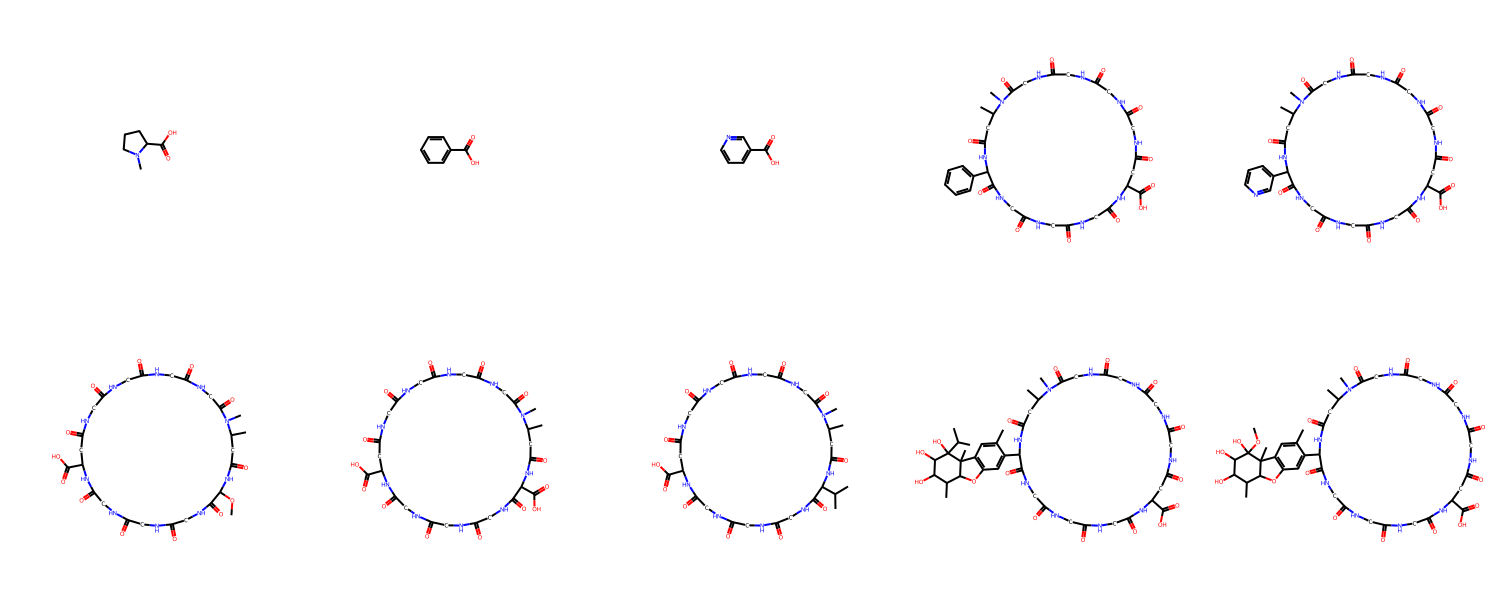

In [6]:
prods = [next(ms) for x in range(10)]
Draw.MolsToGridImage(prods, molsPerRow=5, subImgSize=(300, 300))

# 3. 基于 EnumerateLibrary 进行组合化学
RDKit 还支持使用组合化学库进行大规模分子生成。

#### 反应解析

反应物：
* [C:1]=[O:2] → 羰基化合物 (如醛或酮)
* [NH2:3] → 氨基 (NH₂)
  
生成物：
* [C:1]([O:2])-[NH2:3] → 酰胺 (Amide)，即 氨基取代羰基化合物，形成酰胺键 (C-N 连接)。

这通常表示 羧酸 (R-COOH) 或 酰氯 (R-COCl) 与 氨基 (NH₂) 形成酰胺 (R-CONH₂)。

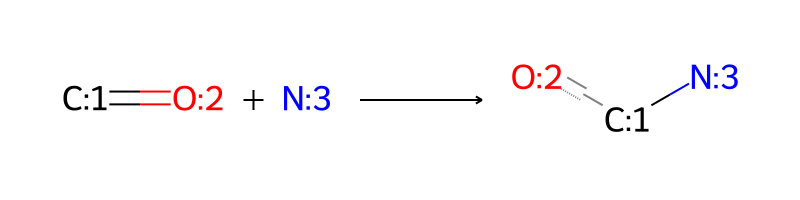

In [7]:
from rdkit.Chem import rdChemReactions

# 定义一个简单的加成反应
rxn = rdChemReactions.ReactionFromSmarts('[C:1]=[O:2].[NH2:3]>>[C:1]([O:2])-[NH2:3]')

# 绘制反应示意图
Draw.ReactionToImage(rxn)

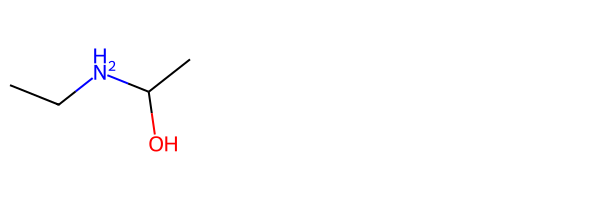

In [8]:
# 反应物
reactants = (Chem.MolFromSmiles('CC=O'), Chem.MolFromSmiles('NCC')) # 乙醛 + 乙胺

# 生成产物
products = rxn.RunReactants(reactants)

# 显示产物
Draw.MolsToGridImage([p[0] for p in products], molsPerRow=3, subImgSize=(200, 200))

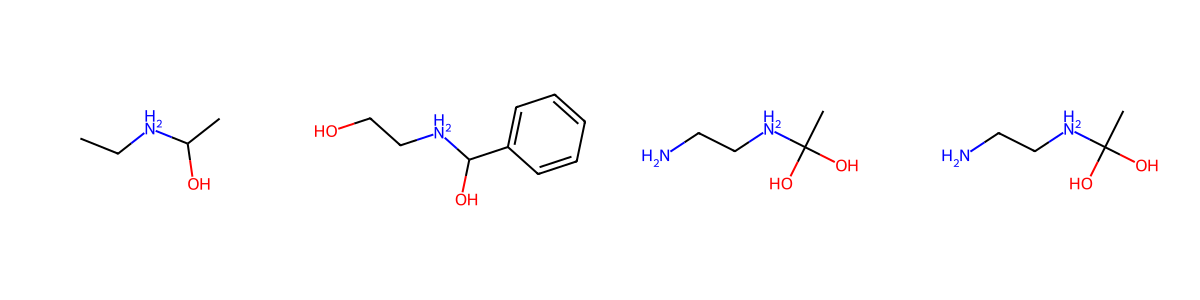

In [9]:
# 多个反应物
reactants_list = [
    (Chem.MolFromSmiles('CC=O'), Chem.MolFromSmiles('NCC')),  # 乙醛 + 乙胺
    (Chem.MolFromSmiles('C1=CC=CC=C1C=O'), Chem.MolFromSmiles('NCCO')),  # 苯甲醛 + 氨基乙醇
    (Chem.MolFromSmiles('CC(=O)O'), Chem.MolFromSmiles('NCCN'))  # 乙酸甲酯 + 乙二胺
]

# 运行多个反应
all_products = []
for reactants in reactants_list:
    products = rxn.RunReactants(reactants)
    if products:
        all_products.extend([p[0] for p in products])  # 取所有产物

# 绘制产物
Draw.MolsToGridImage(all_products, molsPerRow=4, subImgSize=(300, 300))

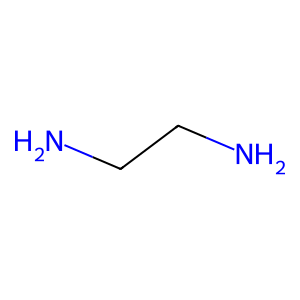

In [10]:
# 乙二胺
Draw.MolToImage(Chem.MolFromSmiles('NCCN'))